# RNAforest: RNA Localization Patterns

**Author**: Clarence Mah | **Last Updated**: 3/18/2023

Here we will analyze cultured 3T3 mouse embryonic stem cells in which 10k genes are spatially profiled with seqFISH+ in [Eng. et al 2019](https://doi.org/10.1038/s41586-019-1049-y). The dataset here consists of 211 cells, each with cell/nuclear segmentation masks and 2D transcript coordinates. Here we showcase how Bento enables subcellular analysis of spatial transcriptomics data.

<img src="../_static/tutorial_img/bento_workflow.png" alt="Bento Workflow" width="1200">

## Load Libraries

We will be using `bento` for subcellular spatial analysis and visualization, along with `scanpy` for handling single-cell gene expression data.

<div class="alert alert-info">

Note

Similar to other tools in the python single-cell omics ecosystem, `bento` adopts an API organized under a set of modules including:

- `bento.io`: reading and writing data stored in the `AnnData` format, customized to hold molecular coordinates and segmentation masks

- `bento.pp`: preprocessing data

- `bento.tl`: subcellular spatial analyses

- `bento.pl`: visualizing subcellular-resolution spatial data, localization pattern statistics, and more

</div>

In [13]:
%load_ext autoreload
%autoreload 2

import bento
import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

Let's grab the `seqFISH+` dataset. This will download the dataset into `data_home`, which by default is set to `~/bento-data`.

The loaded object is an `AnnData` object, structured similarly to single-cell omics anlayses, where observations are cells, features are genes, and the main matrix is an expression count matrix. To store subcellular information, `bento` stores:
- Molecular coordinates: formatted as `DataFrames` in `uns['points']`
- Segmentation masks: formatted as `geopandas.GeoSeries` in `obs` denoted as `{}_shape`. In this case, we have cell and nuclear segmentations stored in `cell_shape` and `nucleus_shape` respectively.

In [2]:
adata = bento.datasets.load_dataset("merfish_raw")
adata

AnnData object with n_obs × n_vars = 1153 × 135
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points'
    layers: 'spliced', 'unspliced'

What does our data look like? For starters, we can visualize molecules as their spatial density in a single field of view. You may notice some cells are missing nuclear masks for one reason or another. We can handle this with [Quality Control](#Quality-Control) metrics in the next section.

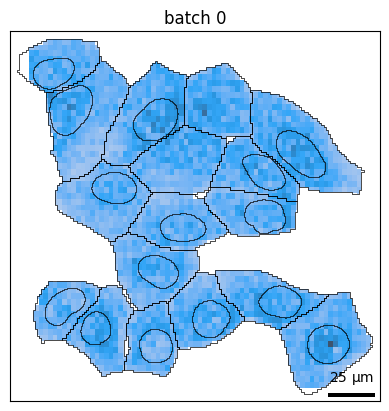

In [7]:
bento.pl.density(adata)

Filter out cells without a nucleus.

In [3]:
adata = adata[adata.obs["nucleus_shape"] != None]
bento.ut.sync(adata)

Trying to set attribute `._uns` of view, copying.


0it [00:00, ?it/s]

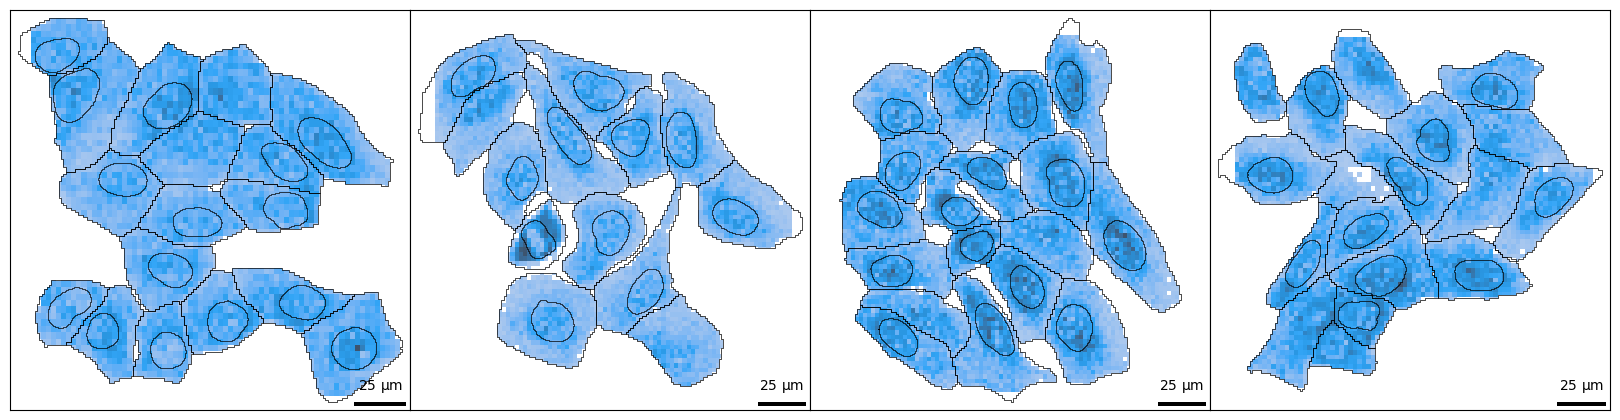

In [4]:
batches = adata.obs["batch"].unique()  # get unique batches
nbatches = len(batches)
print(f"There are a total of {nbatches} fields of view.")

ncols = 4  # 5 columns
nrows = 1
fig, axes = plt.subplots(1, 4, figsize=(ncols * 4, nrows * 4))  # instantiate figure

# Plot single field of view at a time
for b, ax in tqdm(zip(batches, axes.flat)):
    bento.pl.density(
        adata,
        batch=b,
        ax=ax,
        axis_visible=False,
        frame_visible=True,
        square=True,
        title="",
    )

# remove empty axes
for ax in axes.flat[nbatches:]:
    ax.remove()

# remove space between axes
plt.subplots_adjust(wspace=0, hspace=0, bottom=0, top=1, left=0, right=1)

## Spatial summary statistics

You can get a quick summary of cell and nuclear properties, including area, shape i.e. "aspect ratio", and RNA density. Learn how to compute additional properties here

In [4]:
bento.tl.obs_stats(adata)

  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_density, cell_area, cell_aspect_ratio


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + nucleus_density, nucleus_area, nucleus_aspect_ratio


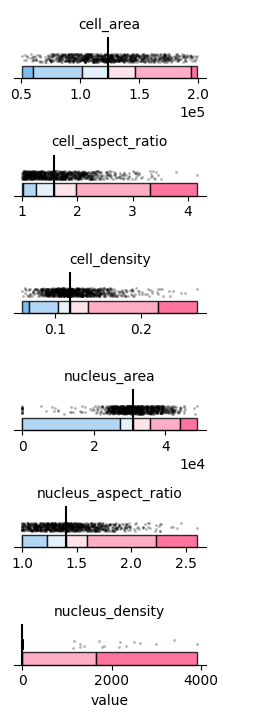

In [7]:
bento.pl.obs_stats(adata, s=2)

## RNAflux

start 5:14pm

In [3]:
bento.tl.flux(adata)

  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_raster
    uns:
        + cell_raster


  0%|          | 0/1153 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_raster
    uns:
        + flux, cell_raster, point_sets, flux_genes, flux_variance_ratio, flux_embed, flux_color


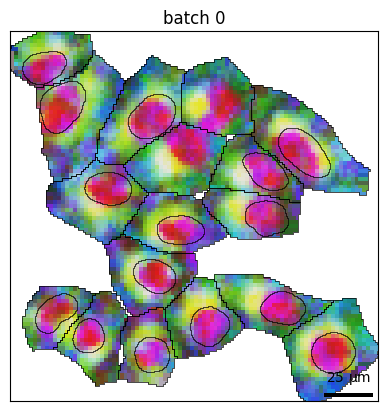

In [6]:
bento.pl.flux(adata)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

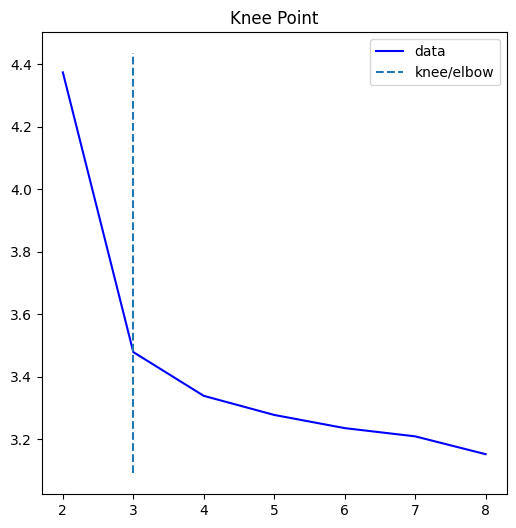

  0%|          | 0/1153 [00:00<?, ?it/s]

  0%|          | 0/1153 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + fluxmap2_shape, fluxmap1_shape, fluxmap3_shape


In [8]:
bento.tl.fluxmap(adata)

AttributeError: PatchCollection.set() got an unexpected keyword argument 'palette'

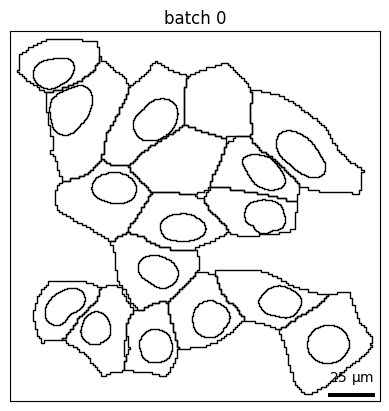

In [24]:
bento.pl.fluxmap(adata)

## Predict Subcellular Localization Patterns

Now that we have a sense of our data, we will apply a pattern classifier to predict and annotate subcellular localization patterns for our dataset. A single "sample" refers to the set of points corresponding for a given gene in a single cell.

<img src="../_static/tutorial_img/bento_pattern_annotation.png" alt="Bento Pattern Annotation Workflow" width="800">

### Calculate spatial features

These features are used by the classifier to predict patterns for each sample. The entire dataset takes ~8 hours to process, therefore we have provided precomputed features to proceed with the analysis.

<div class="alert alert-info">

Note

Why does it take so long? Unlike single-cell analysis which uses expression counts, we are computing spatial relationships considering every molecule! In this dataset there are >4 million molecules and multiple high-resolution polygons for every cell.

</div>

In [ ]:
bento.tl.analyze

### Predict Subcellular Patterns

Predict the subcellular pattern for every sample (by default, only samples with count >= 5). The five subcellular patterns we can predict are:

- **cell edge**: near the cell membrane
- **cytoplasmic**: mostly outside the nucleus in the cytoplasm
- **nuclear**: most in the nucleus
- **nuclear edge**: near the nuclear membrane, either
- **none**: none of the above patterns, more or less randomly distributed

Here are [more details](../howitworks.md#spatial-features) about the spatial statistics used as input features for classification.


<img src="../_static/tutorial_img/subcellular_patterns.png" alt="Subcellular Patterns" width="300">

start 2:42pm
end 3:14pm

~ 30 minutes

In [37]:
bento.tl.lp(adata)

Calculating cell features...


  0%|          | 0/5 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_span, cell_maxx, cell_maxy, cell_miny, cell_minx, cell_radius, cell_raster
    uns:
        + cell_raster
Processing point features...


  0%|          | 0/1022 [00:00<?, ?it/s]

Saving results...
Done.
AnnData object modified:
    obs:
        + cell_span, cell_maxx, cell_maxy, cell_miny, cell_minx, cell_radius, cell_raster
    uns:
        + cell_raster, cell_gene_features
Calculating cell features...


  0%|          | 0/2 [00:00<?, ?it/s]

Processing point features...


  0%|          | 0/1022 [00:00<?, ?it/s]

Saving results...
Done.
AnnData object modified:
    obs:
        + cell_span, cell_maxx, cell_maxy, cell_miny, cell_minx, cell_radius, cell_raster
    uns:
        + lpp, cell_raster, cell_gene_features, lp


We can view the observed pattern frequencies to get a rough idea of how transcripts are localizing.

In [ ]:
bento.pl.lp_dist(adata, percentage=True)

We can also visualize the localization of each gene where the point position denotes the balance between subcellular localization pattern frequencies. The color denotes the gene's most frequent pattern. Interestingly, we see a wide range of variability in localization. A large number of genes are pulled towards none while nuclear enriched genes show strong bias and a high fraction of cells.

In [ ]:
bento.tl.lp_stats(adata, "gene")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gene
AFAP1           99.9
AFF4           100.0
AGAP1          100.0
AGO3            99.5
AGPS           100.0
               ...  
notarget001     85.8
notarget002     97.0
notarget003     98.9
notarget004     98.2
notarget005     91.0
Name: Fraction of cells\n in group (%), Length: 135, dtype: float64


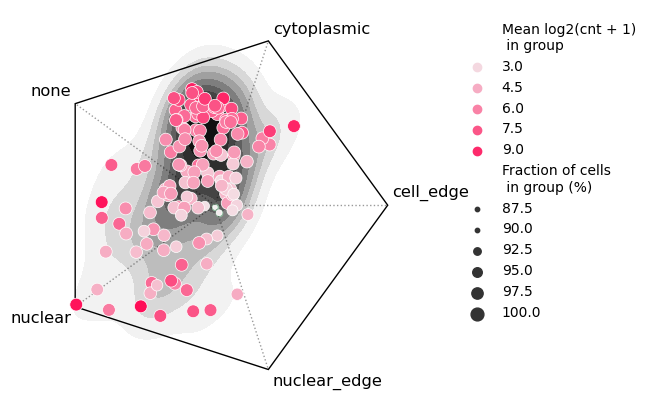

In [64]:
bento.pl.lp_genes(adata, sizes=(10, 85), size_norm=(90, 100))

## Colocalization analysis

compartment specific... gene pairs

TODO update image
<img src="../_static/tutorial_img/tensor_decomposition.png" alt="Tensor Decomposition" width="800">

In [3]:
adata.obs["cytoplasm_shape"] = bento.geo.get_shape(
    adata, "cell_shape"
) - bento.geo.get_shape(adata, "nucleus_shape")
adata.uns["points"]["cytoplasm"] = (
    adata.uns["points"]["nucleus"].astype(int) < 0
).astype(int)

<div class="alert alert-info">

Note
    
Runtime: 3 minutes
</div>

In [5]:
bento.tl.coloc_quotient(adata, shapes=["cytoplasm_shape", "nucleus_shape"])

cytoplasm_shape:   0%|          | 0/1153 [00:00<?, ?it/s]

nucleus_shape:   0%|          | 0/1151 [00:00<?, ?it/s]

AnnData object modified:
    uns:
        + clq


<div class="alert alert-info">

Note
    
Runtime: 12 minutes
</div>

Preparing tensor...
(2, 1153, 18225)
:running: Decomposing tensor...


Device cpu:   0%|          | 0/5 [00:00<?, ?it/s]

:heavy_check_mark: Done.
AnnData object modified:
    uns:
        + factors_error, tensor_names, tensor, tensor_labels, factors


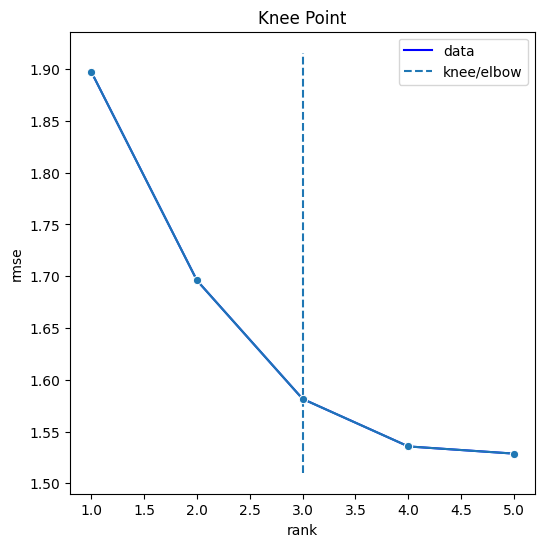

In [6]:
bento.tl.colocation(adata, ranks=range(1, 6))

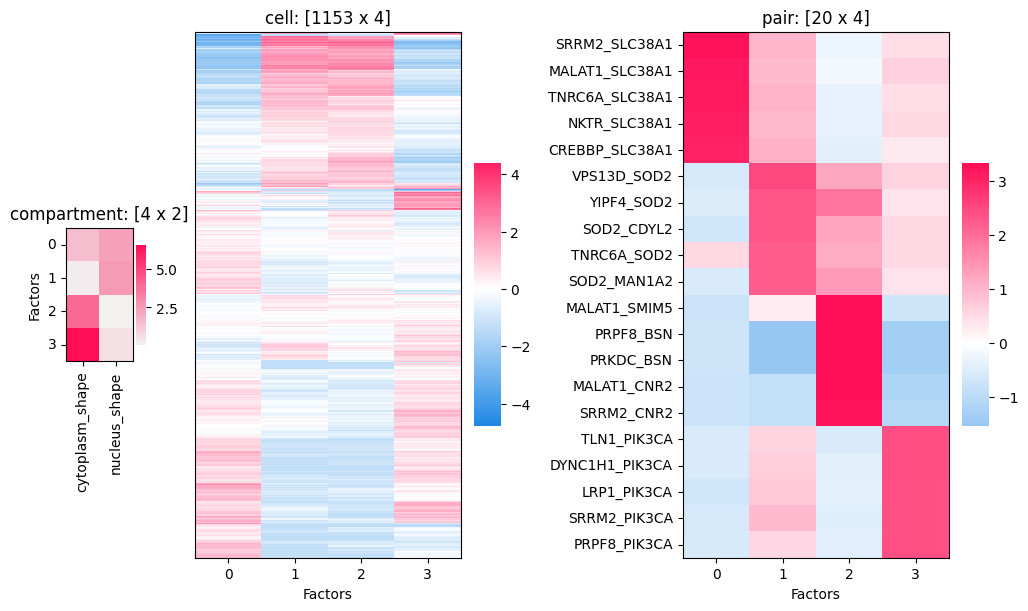

In [62]:
bento.pl.colocation(
    adata,
    4,
    n_top=[None, None, 5],
    z_score=[False, True, True],
    cluster=[False, True, False],
    show_labels=[True, False, True],
    self_pairs=False,
)